 # 汽车计算流体动力学（CFD）数据可视化

 本示例展示如何可视化来自 `CarCFDDataset <car_cfd_dataset_api>` 的非结构化网格数据。

 本教程演示了如何处理计算流体动力学（CFD）模拟生成的非结构化网格数据：

 1. 探索汽车的3D几何结构

 2. 分析表面压力场的分布规律

 3. 理解神经算子训练中查询点的作用（压力场预测是空气动力学分析和神经算子应用的核心场景）



 CarCFD 数据集包含以下核心内容：

 - 表征汽车表面的3D三角形网格数据

 - CFD仿真计算得到的表面压力场数据

 - 用于神经算子（Neural Operator）训练的查询点（Query Points）

 ## 步骤1：导入依赖库

 导入 neuralop 核心库及数据处理、可视化所需的依赖库

In [27]:
# 数值计算基础库，用于数组处理
import numpy as np
# PyTorch核心库，用于张量运算（神经算子框架基于PyTorch）
import torch
# 绘图基础库，用于配置全局绘图样式
import matplotlib
# 绘图可视化核心库
import matplotlib.pyplot as plt
# 从neuralop数据集模块导入迷你版汽车CFD数据集加载函数
from neuralop.data.datasets import load_mini_car

# 配置全局字体大小，统一可视化样式
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号
# font = {"size": 12}
# matplotlib.rc("font", **font)

# 设置随机种子，保证实验结果可复现
torch.manual_seed(0)
np.random.seed(0)


 ## 步骤2：理解数据集结构

 MeshDataModule 格式的数据集以字典形式存储张量和标量信息，核心是编码汽车表面的3D三角形网格：

 - 每个样本包含三角形顶点坐标、三角面质心坐标

 - 压力场数据：通过OpenFOAM求解器模拟不同入口风速下的3D纳维-斯托克斯方程，得到每个顶点的压力值

 - 入口风速标量：每个样本对应一个入口风速条件

 - 本示例使用预处理后的张量格式迷你数据集（完整数据集存储为三角形网格文件）

In [28]:
# 加载迷你版汽车CFD数据集（包含少量预处理样本）
data_list = load_mini_car()
# 取第一个样本作为演示（所有样本结构一致）
sample = data_list[0]
# 打印样本的键值，查看数据集包含的核心字段
print(f"数据集样本包含的键值: {sample.keys()}")


尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages
数据集样本包含的键值: dict_keys(['vertices', 'vertex_normals', 'triangle_normals', 'centroids', 'triangle_areas', 'distance', 'closest_points', 'normalized_triangle_areas', 'press', 'query_points'])


 ## 步骤3：可视化汽车表面的压力分布

 基于顶点坐标和压力值，绘制3D散点图展示压力在汽车表面的分布规律

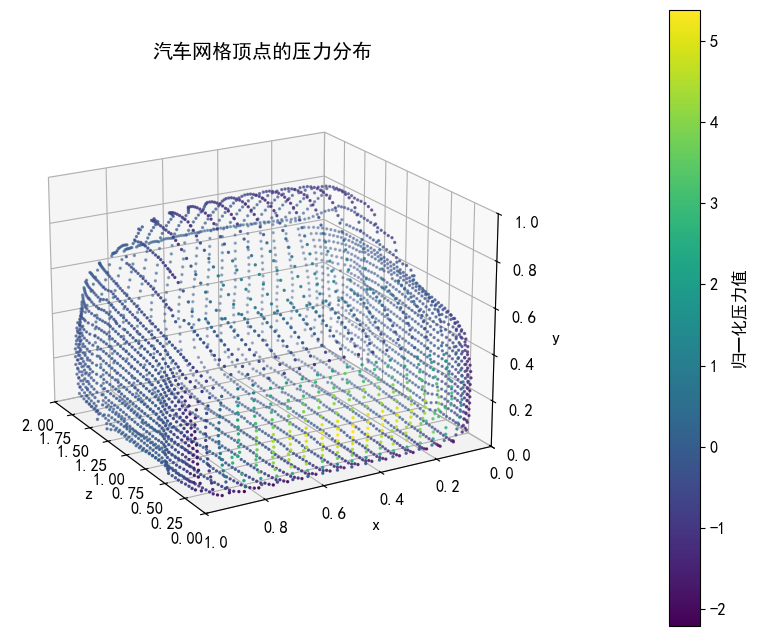

In [29]:
# 创建绘图画布，设置尺寸为10x8英寸
fig = plt.figure(figsize=(10, 8))
# 添加3D投影的子图（核心：启用3D绘图模式）
ax = fig.add_subplot(projection="3d")

# 数据集默认归一化到单位立方体，为了更清晰展示高度，将z轴坐标放大2倍
# 绘制3D散点图：x/y/z为顶点坐标，s=2设置点大小，c=压力值（颜色映射），cmap=viridis配色方案
scatter = ax.scatter(
    sample["vertices"][:, 0],  # 所有顶点的x坐标（张量第一列）
    sample["vertices"][:, 1],  # 所有顶点的y坐标（张量第二列）
    sample["vertices"][:, 2] * 2,  # z坐标放大2倍，增强可视化效果
    s=2,  # 散点大小
    c=sample["press"].numpy(),  # 压力值（从张量转为numpy数组）
    cmap="viridis"  # 颜色映射（蓝-绿-黄，对应压力从低到高）
) 
# 设置x轴范围，适配归一化后的数据
ax.set_xlim(0, 1)
# 设置y轴范围
ax.set_ylim(0, 1)
ax.set_zlim(0, 2)  # z轴范围扩大到2，适配放大后的高度
# 设置坐标轴标签
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
# 调整3D视角：elev=仰角，azim=方位角，roll=旋转角，vertical_axis=垂直轴为y
ax.view_init(elev=20, azim=150, roll=0, vertical_axis="y")
# 设置子图标题
ax.set_title("汽车网格顶点的压力分布")
# 添加颜色条（图例）：pad=0.2调整间距，label标注颜色含义，ax指定绑定的子图
fig.colorbar(scatter, pad=0.2, label="归一化压力值", ax=ax)
# 强制绘制（确保可视化渲染）
plt.draw()


 ## 步骤4：可视化神经算子训练的查询点

 CarCFDDataset 每个样本包含一组潜在查询点（Latent Query Points），用于几何感知模型中FNO（傅里叶神经算子）的函数学习。

 本小节将查询点叠加在汽车表面顶点上，展示其空间分布。

Text(0.5, 0.92, '查询点与汽车表面顶点的空间分布')

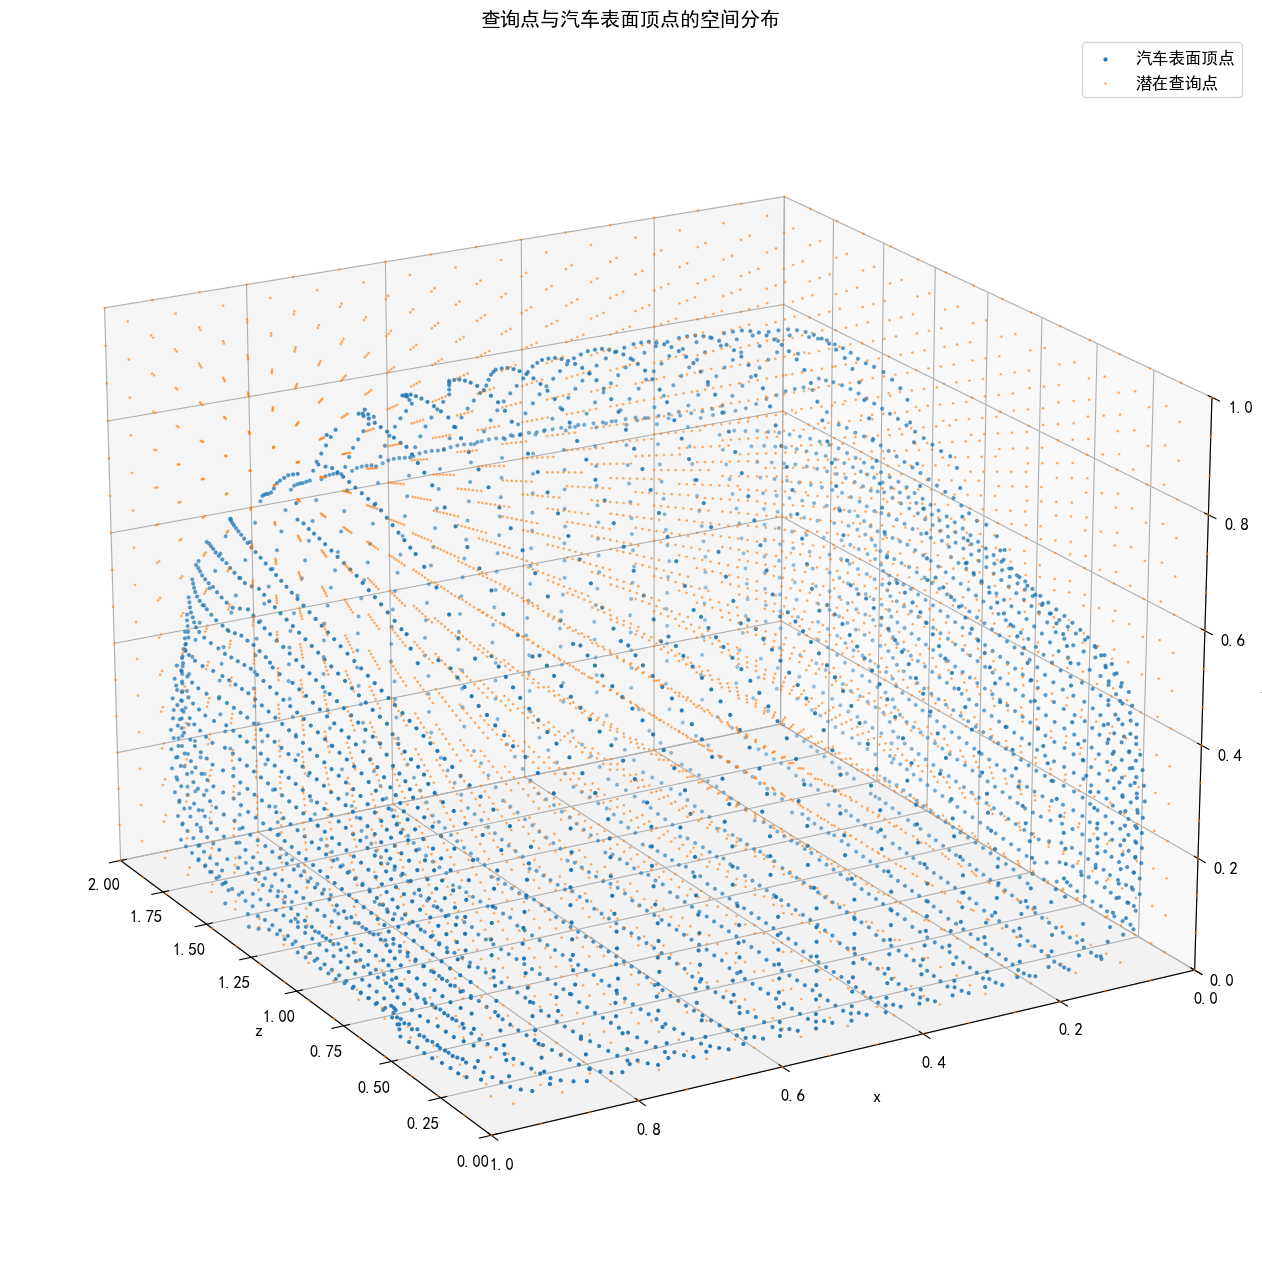

In [30]:
# 创建画布，尺寸8x10英寸
fig = plt.figure(figsize=(16, 20))
# 添加3D子图
ax = fig.add_subplot(projection="3d")
# 绘制汽车表面顶点：s=4增大点大小，标注为"Car surface"
scatter = ax.scatter(
    sample["vertices"][:, 0],
    sample["vertices"][:, 1],
    sample["vertices"][:, 2] * 2,
    s=4,
    label="汽车表面顶点"
)
# 处理查询点：将立方体形状的张量展平为N×3的点云格式（N个查询点，每个点3个坐标）
queries = sample["query_points"].view(-1, 3)
# 绘制查询点：s=1缩小点大小，alpha=0.5设置透明度，避免遮挡顶点
ax.scatter(
    queries[:, 0],
    queries[:, 1],
    queries[:, 2] * 2,
    s=1,
    alpha=0.5,
    label="潜在查询点"
)

# 设置坐标轴范围，保持与前图一致
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 2)
# 设置坐标轴标签
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
# 添加图例（区分顶点和查询点）
ax.legend()
# 调整3D视角，与压力分布图一致，便于对比
ax.view_init(elev=20, azim=150, roll=0, vertical_axis="y")
# 设置标题
ax.set_title("查询点与汽车表面顶点的空间分布")


 ## 步骤5：3D点云的邻域搜索

 邻域搜索是几何深度学习/神经算子的核心操作（用于构建点云的局部依赖关系）。

 本小节基于汽车表面3D点云，演示如何为指定查询点搜索邻域点。

 （注：neuralop.layers.neighbor_search 中演示过2D点云邻域搜索，此处扩展到3D场景）

In [31]:
# 导入neuralop原生邻域搜索函数
from neuralop.layers.neighbor_search import native_neighbor_search

# 提取汽车表面顶点张量（N×3，N为顶点数量）
verts = sample["vertices"]
# 选取第1700个查询点作为示例（可替换为任意查询点）
query_point = queries[1700]
# 执行邻域搜索：
# - data: 待搜索的点云（汽车顶点）
# - queries: 待查询的点（需扩展维度为1×3，匹配函数输入格式）
# - radius: 邻域搜索半径（0.5为归一化后的距离）
nbr_data = native_neighbor_search(
    data=verts,
    queries=query_point.unsqueeze(0),  # 扩展维度：从(3,)→(1,3)
    radius=0.5
)


 ## 步骤6：可视化邻域搜索结果

 绘制单个查询点及其在汽车表面的邻域点，直观展示邻域搜索的效果

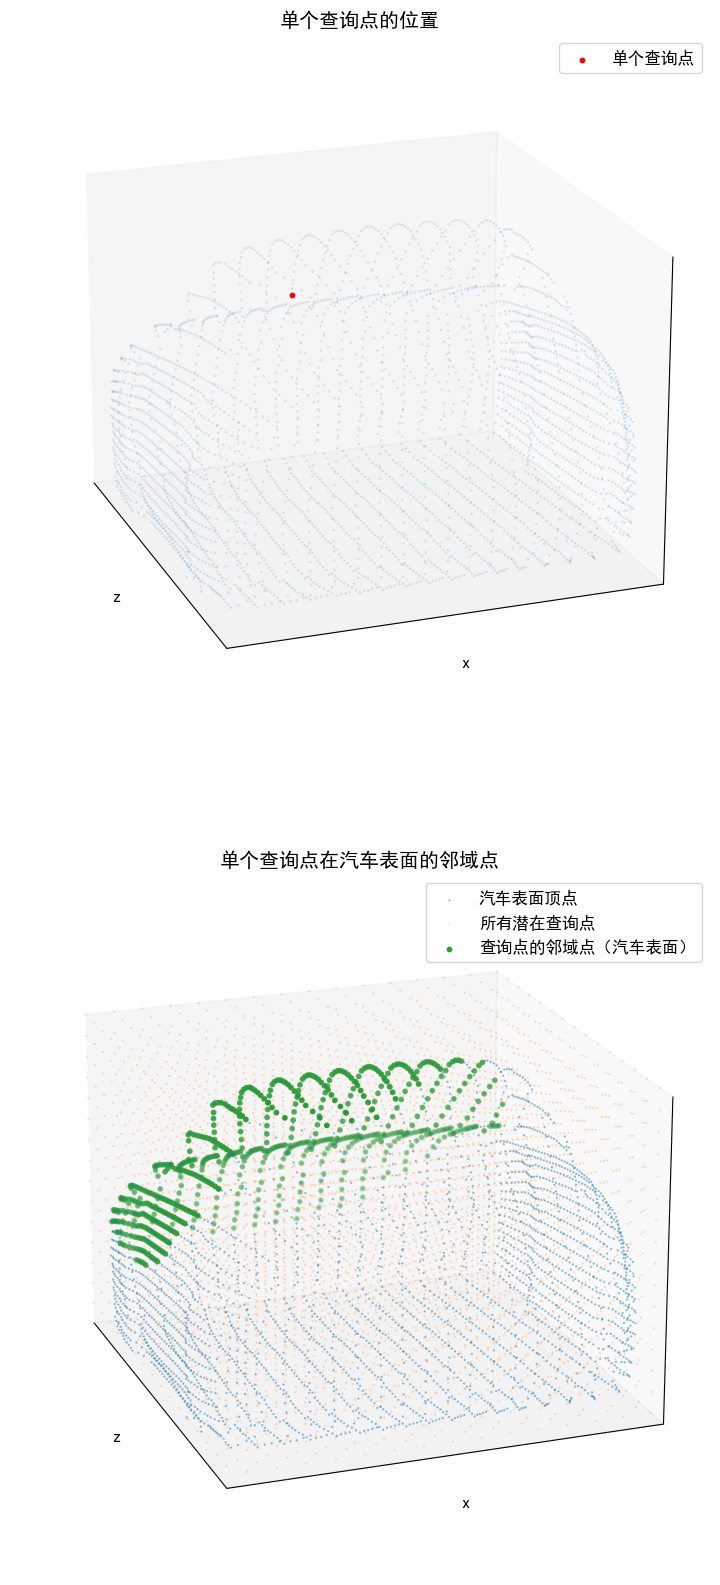

In [32]:
# 创建画布，尺寸8x10英寸
fig = plt.figure(figsize=(16, 20))
# 分两行一列绘制子图：第一行展示查询点，第二行展示邻域点
ax1 = fig.add_subplot(2, 1, 1, projection="3d")
ax2 = fig.add_subplot(2, 1, 2, projection="3d")
# 从邻域搜索结果中提取邻域点的索引，并获取对应的顶点坐标
neighbors = verts[nbr_data["neighbors_index"]]

# 第一个子图：仅展示单个查询点与汽车表面
ax1.scatter(
    verts[:, 0], verts[:, 1], verts[:, 2]*2,
    s=1, alpha=0.1  # 顶点设为透明小点，避免遮挡查询点
)
# 绘制查询点：红色、大点（s=10），标注为"Single query"
ax1.scatter(
    query_point[0], query_point[1], query_point[2]*2,
    s=10, c="red", label="单个查询点"
)
# 调整3D视角（与前图不同，便于聚焦查询点）
ax1.view_init(elev=20, azim=-20, roll=0, vertical_axis="y")
# 添加图例
ax1.legend()
# 设置坐标轴范围
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_zlim(0, 2)
# 设置坐标轴标签
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
# 隐藏坐标轴刻度（简化可视化）
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
# 关闭网格线（简化可视化）
ax1.grid(False)
# 设置子图标题
ax1.set_title("单个查询点的位置")

# 第二个子图：展示汽车表面、所有查询点、单个查询点的邻域点
ax2.scatter(
    verts[:, 0], verts[:, 1], verts[:, 2]*2,
    s=0.5, alpha=0.4, label="汽车表面顶点"
)
# 绘制所有潜在查询点（透明小点）
ax2.scatter(
    queries[:, 0], queries[:, 1], queries[:, 2]*2,
    s=0.5, alpha=0.2, label="所有潜在查询点"
)
# 绘制当前查询点的邻域点（大点，突出显示）
ax2.scatter(
    neighbors[:, 0], neighbors[:, 1], neighbors[:, 2]*2,
    s=10, label="查询点的邻域点（汽车表面）"
)
# 添加图例
ax2.legend()
# 设置坐标轴范围
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_zlim(0, 2)
# 设置坐标轴标签
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
# 调整视角（与第一个子图一致）
ax2.view_init(elev=20, azim=-20, roll=0, vertical_axis="y")
# 隐藏坐标轴刻度
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
# 关闭网格线
ax2.grid(False)
# 设置子图标题
ax2.set_title("单个查询点在汽车表面的邻域点")

# 强制绘制
plt.draw()


 ## 步骤7：可视化查询点与邻域点的连接关系

 自定义3D箭头类，绘制查询点到每个邻域点的箭头，直观展示邻域搜索的空间关联

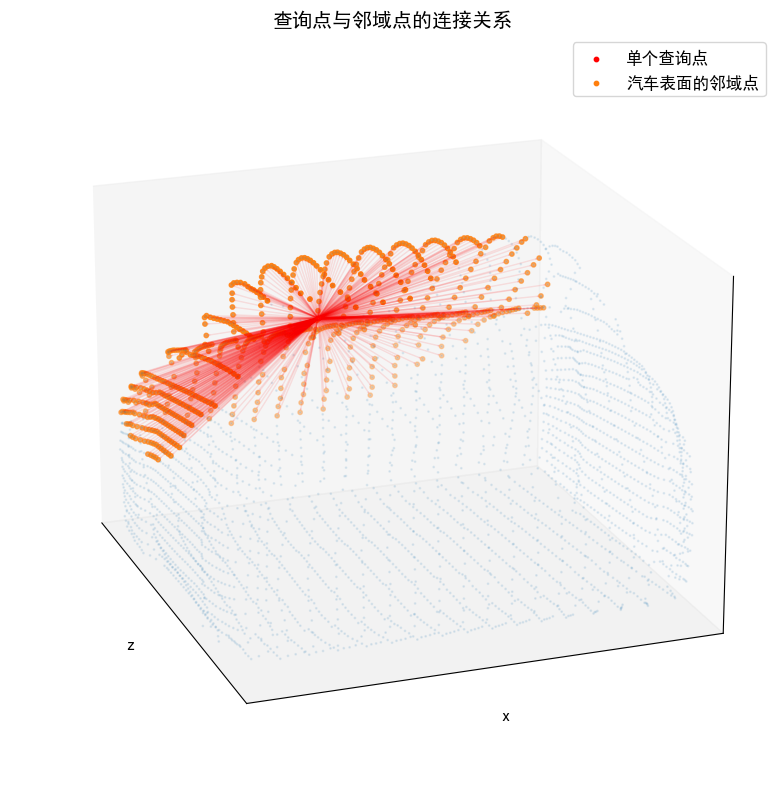

In [34]:
# 导入必要库（重复导入仅为代码完整性，实际可省略）
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# 自定义3D箭头类（继承自FancyArrowPatch）
# 解决matplotlib原生不支持3D箭头的问题，通过投影实现3D箭头绘制
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        # 初始化父类：设置初始坐标为(0,0)（后续通过投影更新）
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        # 存储3D坐标：xs=[起点x, 终点x], ys=[起点y, 终点y], zs=[起点z, 终点z]
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        # 3D坐标投影到2D平面（适配matplotlib的2D渲染逻辑）
        xs3d, ys3d, zs3d = self._verts3d
        # 执行3D→2D投影变换
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        # 更新箭头的2D坐标（起点和终点）
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        # 返回z轴最小值（用于深度排序，确保箭头渲染层级正确）
        return np.min(zs)

# 创建画布，尺寸8x10英寸
fig = plt.figure(figsize=(8, 10))
# 添加3D子图
ax1 = fig.add_subplot(projection="3d")
# 提取邻域点坐标（复用之前的邻域搜索结果）
neighbors = verts[nbr_data["neighbors_index"]]

# 绘制汽车表面顶点（透明小点，作为背景）
ax1.scatter(
    verts[:, 0], verts[:, 1], verts[:, 2]*2,
    s=1, alpha=0.1
)
# 绘制查询点（红色大点，突出显示）
ax1.scatter(
    query_point[0], query_point[1], query_point[2]*2,
    s=10, c="red", label="单个查询点"
)
# 绘制邻域点（大点，标注为邻域点）
ax1.scatter(
    neighbors[:, 0], neighbors[:, 1], neighbors[:, 2]*2,
    s=10, label="汽车表面的邻域点"
)

# 调整3D视角（与前图一致）
ax1.view_init(elev=20, azim=-20, roll=0, vertical_axis="y")
# 添加图例
ax1.legend()
# 设置坐标轴范围
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_zlim(0, 2)
# 设置坐标轴标签
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
# 隐藏坐标轴刻度
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
# 关闭网格线
ax1.grid(False)
# 设置子图标题
ax1.set_title("查询点与邻域点的连接关系")

# 定义箭头样式参数：
# - mutation_scale: 箭头头部大小
# - arrowstyle: 箭头样式（-|> 表示带箭头的直线）
# - color: 箭头颜色（红色）
# - shrinkA/shrinkB: 箭头起点/终点收缩（避免与点重叠）
# - alpha: 透明度（避免箭头遮挡点）
arrow_prop_dict = dict(
    mutation_scale=1,
    arrowstyle="-|>",
    color="red",
    shrinkA=1,
    shrinkB=1,
    alpha=0.1
)

# 遍历每个邻域点，绘制从查询点到邻域点的3D箭头
for nbr in neighbors:
    # 创建3D箭头实例：
    # xs: [查询点x, 邻域点x]
    # ys: [查询点y, 邻域点y]
    # zs: [查询点z×2, 邻域点z×2]（z轴放大2倍，与之前可视化一致）
    a = Arrow3D(
        [query_point[0], nbr[0]],
        [query_point[1], nbr[1]],
        [query_point[2] * 2, nbr[2] * 2],
        **arrow_prop_dict,
    )
    # 将箭头添加到子图中
    ax1.add_artist(a)

# 调整子图间距（避免重叠）
fig.tight_layout()
# 强制绘制
plt.draw()